In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import os
import torch.nn.functional as F
import seaborn as sns
import numpy as np  # Import NumPy as np




In [5]:
custom_data_path = '/kaggle/input/brain-tumor-mri-dataset'
trainset = ImageFolder(root=os.path.join(custom_data_path, 'Training'), transform=transforms.ToTensor())


In [3]:
print(len(trainset))

5712


In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=False)
data = next(iter(trainloader))[0]
mean = data.mean(axis=(0, 2, 3))
std = data.std(axis=(0, 2, 3))

In [7]:
print(mean,std)

tensor([0.1207, 0.1207, 0.1207]) tensor([0.1507, 0.1507, 0.1507])


In [8]:
normalize = transforms.Normalize(mean=mean, std=std)


In [9]:
# Define data augmentation and normalization transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
   normalize
])

In [10]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    normalize
])

In [11]:


batch_size = 128
# Use ImageFolder to create a dataset
#labels are given as 0,1,2
#first folder has label 0 and so on
trainset = ImageFolder(root=os.path.join(custom_data_path, 'Training'), transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)



In [12]:
testset = ImageFolder(root=os.path.join(custom_data_path, 'Testing'), transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [13]:
print(len(trainset) + len(testset))

7023


In [14]:
# Define the ResNet model

resnet50 = models.resnet50(pretrained=False, num_classes=4)  # You can choose a different ResNet variant
#models.wide_resnet50_2
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Training loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
num_epochs = 100
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    # Set the device to CUDA
    device = torch.device("cuda")
    print("Cuda")
else:
    # If CUDA is not available, use the CPU
    device = torch.device("cpu")


Cuda


In [17]:
for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if epoch == 49:  # 50th epoch
        checkpoint_path = "res50_" + str(epoch) +"_epoch.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': resnet50.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_path)
        print(f"Model saved at epoch {epoch +1}")
        

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

Epoch 1, Loss: 4.593721471892463
Epoch 2, Loss: 1.6595318290922376
Epoch 3, Loss: 1.2982162687513563
Epoch 4, Loss: 1.1937900172339546
Epoch 5, Loss: 1.170573721991645
Epoch 6, Loss: 1.2018964767456055
Epoch 7, Loss: 0.9257151431507534
Epoch 8, Loss: 0.8202917059262593
Epoch 9, Loss: 0.7661530454953511
Epoch 10, Loss: 0.7586043821440802
Epoch 11, Loss: 0.635943517420027
Epoch 12, Loss: 0.652260551850001
Epoch 13, Loss: 1.195836477809482
Epoch 14, Loss: 0.8666950901349385
Epoch 15, Loss: 0.7365692575772603
Epoch 16, Loss: 0.6532172719637553
Epoch 17, Loss: 0.590629028611713
Epoch 18, Loss: 0.5404322849379646
Epoch 19, Loss: 0.549139228132036
Epoch 20, Loss: 0.5238053129778968
Epoch 21, Loss: 0.47233941753705344
Epoch 22, Loss: 0.47038733959198
Epoch 23, Loss: 0.41421814428435433
Epoch 24, Loss: 0.410493893093533
Epoch 25, Loss: 0.37885323034392465
Epoch 26, Loss: 0.36098146405484943
Epoch 27, Loss: 0.34018913176324633
Epoch 28, Loss: 0.30653670993116167
Epoch 29, Loss: 0.342269229888916

In [18]:
torch.save(resnet50.state_dict(), 'resnet50_full.pth')

In [24]:
#resnet_load = models.resnet50(pretrained=False, num_classes=4)  # You can choose a different ResNet variant


In [27]:
#checkpoint_path = '/kaggle/working/res50_normal_5.pth'
#checkpoint = torch.load(checkpoint_path)
# Retrieve the components from the checkpoint
#epoch = checkpoint['epoch']
#model_state_dict = checkpoint['model_state_dict']
#optimizer_state_dict = checkpoint['optimizer_state_dict']
#loss = checkpoint['loss']


In [17]:
#resnet_load.load_state_dict(model_state_dict)
#resnet_load.eval()

In [19]:
# Set the model to evaluation mode
resnet50.eval()

correct = 0
total = 0

# Disable gradient calculation during inference
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)  # Move data to the appropriate device (e.g., CPU or GPU)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet50(images)
        
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Count total and correctly predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = (correct / total) * 100.0

print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Accuracy of the model on the test dataset: 97.56%


In [52]:
chest_path = '/kaggle/input/labeled-chest-xray-images'
testset_chest = ImageFolder(root=os.path.join(chest_path, 'chest_xray/test'), transform=transform_test)
testloader_chest = torch.utils.data.DataLoader(testset_chest, batch_size=batch_size, shuffle=False, num_workers=2)

In [51]:
print(len(testset_chest))

624


In [53]:
def get_softmax_scores(model, dataloader):
    scores = []
    outputs_raw = []
    device = next(model.parameters()).device  # Get the device of the model's parameters

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            outputs = model(inputs)
            softmax_scores = F.softmax(outputs, dim=1)
            scores.append(softmax_scores)
            outputs_raw.append(outputs)

    scores = torch.cat(scores)
    outputs_raw = torch.cat(outputs_raw)
    return scores, outputs_raw

In [54]:
brain_softmax_scores,scores_brain = get_softmax_scores(resnet50, testloader)  # MNIST softmax scores (ID)
print(len(brain_softmax_scores))

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

1311


In [55]:
chest_softmax_scores,scores_chest = get_softmax_scores(resnet50, testloader_chest)  


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

In [56]:
print(len(chest_softmax_scores))

624


In [57]:
threshold = 0.9  # Adjust as needed

def classify_samples(softmax_scores, threshold):
    max_scores, _ = torch.max(softmax_scores, dim=1)
    ood_samples = max_scores < threshold
    return ood_samples,max_scores

In [58]:
brain_ood_samples,max_brain = classify_samples(brain_softmax_scores, threshold)
chest_ood_samples,max_chest = classify_samples(chest_softmax_scores, threshold)

In [59]:
#print(brain_ood_samples,chest_ood_samples)
print(len(brain_softmax_scores))
print(len(chest_softmax_scores))
print(torch.sum(brain_ood_samples).item())
print(torch.sum(chest_ood_samples).item())

1311
624
92
438


/tmp/ipykernel_28/3544167128.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(max_brain_cpu, shade=True, color = "blue")
/tmp/ipykernel_28/3544167128.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(max_chest_cpu, shade=True, color = "yellow")


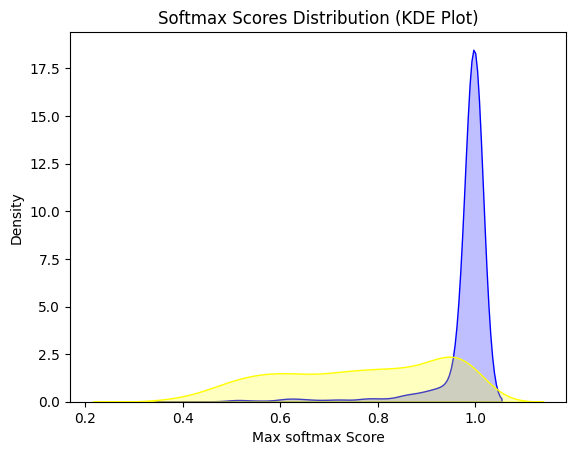

In [60]:
# Transfer tensors from GPU to CPU
max_brain_cpu = max_brain.cpu().numpy()
max_chest_cpu = max_chest.cpu().numpy()
# Create a KDE plot
sns.kdeplot(max_brain_cpu, shade=True, color = "blue")
sns.kdeplot(max_chest_cpu, shade=True, color = "yellow")


# Customize the plot
plt.xlabel("Max softmax Score")
plt.ylabel("Density")
plt.title("Softmax Scores Distribution (KDE Plot)")

# Display the plot or save it to a file
plt.show()

In [72]:
d=2
def energy(out, axis = 1, numpy = True, T = 1, correction = False , ty='not_num'): #actually takes negative energy
    print("Called")

    if ty == 'not_num':
        #print("correct")
        #out = out.detach().numpy()

        #print(out)
        #denominator of softmax np.sum(np.exp(out/T)
        scores = T*np.log(np.sum(np.exp(out/T), axis = axis))
    if correction:
        print("here")
        scores -= T*np.log(d)

    return scores

In [73]:
scores_brain_cpu = scores_brain.cpu().numpy()
scores_chest_cpu = scores_chest.cpu().numpy()
# Energy Scores
ID_energy_score = energy(scores_brain_cpu)
OOD_energy_score = energy(scores_chest_cpu)

Called
Called


/tmp/ipykernel_28/2410324062.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ID_energy_score, shade=True, color = "blue")
/tmp/ipykernel_28/2410324062.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(OOD_energy_score, shade=True, color = "yellow")


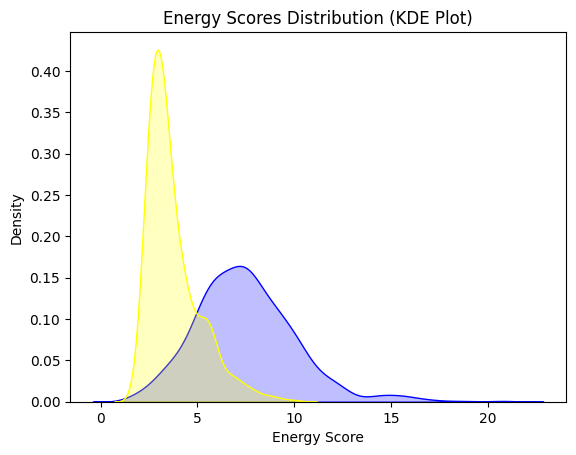

In [74]:
# Create a KDE plot
sns.kdeplot(ID_energy_score, shade=True, color = "blue")
sns.kdeplot(OOD_energy_score, shade=True, color = "yellow")


# Customize the plot
plt.xlabel("Energy Score")
plt.ylabel("Density")
plt.title("Energy Scores Distribution (KDE Plot)")

# Display the plot or save it to a file
plt.show()


In [77]:
import numpy as np
import matplotlib.pyplot as plt

def thresholdize(distID, distOOD, alpha=0.5, plot=True):
    distID = distID[np.isfinite(distID)]
    distOOD = distOOD[np.isfinite(distOOD)]

    densID, binsID, _ = plt.hist(distID, bins=100, density=True, alpha=0.5, label='ID')
    densOOD, binsOOD, _ = plt.hist(distOOD, bins=100, density=True, alpha=0.5, label='OOD')

    if not plot:
        plt.clf()

    widthID = binsID[1] - binsID[0]
    widthOOD = binsOOD[1] - binsOOD[0]
    n = len(densID)

    low = np.min([binsID[0], binsOOD[0]])
    high = np.max([binsID[-1], binsOOD[-1]])
    thresholds = np.linspace(low, high, n)

    massID = np.zeros(n)
    massOOD = np.zeros(n)

    for i, x in enumerate(thresholds):
        massOOD[i] = np.sum(densOOD[binsOOD[:-1] < x]) * widthOOD
        massID[i] = np.sum(densID[binsID[:-1] >= x]) * widthID

    total = 2 * (alpha * massOOD + (1 - alpha) * massID)
    thresIdx = np.argmax(total)
    threshold = thresholds[thresIdx]
    bestTotal = np.max(total)  # not very intuitive when using alpha-thresholding

    if plot:
        plt.vlines(threshold, 0, 1.1 * np.max(densOOD), label='Threshold', linestyles='dashed')
        plt.legend()

        plt.figure()
        plt.plot(thresholds, massID, label='ID mass right')
        plt.plot(thresholds, massOOD, label='OOD mass left')
        plt.plot(thresholds, total, label='Total')
        plt.vlines(threshold, 0, 1.1 * np.max(total), label='Threshold', linestyles='dashed')
        plt.legend()

        falseOOD = 1.0 - massID[thresIdx]
        falseID = 1.0 - massOOD[thresIdx]

        print(f"Fraction of OOD data falsely classified as ID is {falseID:.3g}")
        print(f"Fraction of ID data falsely classified as OOD is {falseOOD:.3g}")

    return threshold


Fraction of OOD data falsely classified as ID is 0.181
Fraction of ID data falsely classified as OOD is 0.146


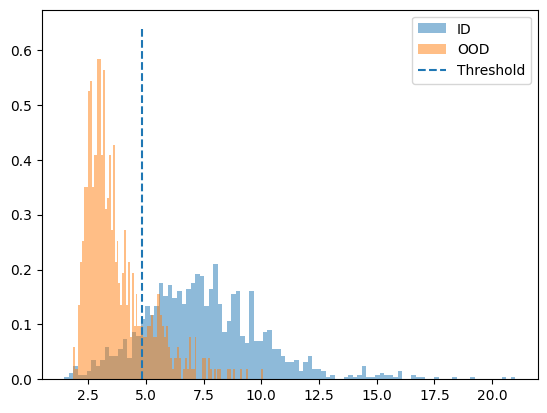

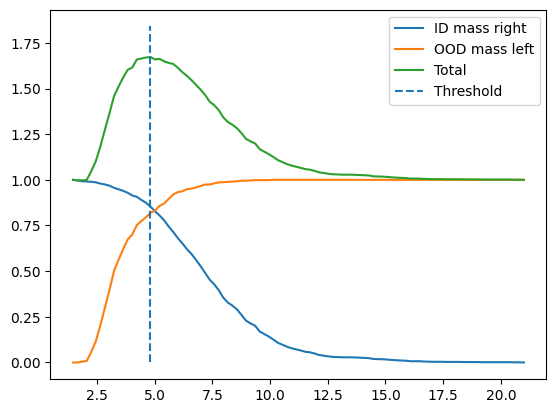

In [78]:
thr = thresholdize(ID_energy_score,OOD_energy_score)